In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from copy import deepcopy
from sklearn.linear_model import LinearRegression

from sympy.solvers import solve
from sympy import *

%matplotlib inline

# MA(q) processes

$$y_t = \alpha_0 \eta_t + \alpha_1 \eta_{t-1} + ... + \alpha_q \eta_{t-q}$$

$$ y_t = \left( \sum_{i=0}^g \alpha_i B^i\right)\eta_t $$

where:
* $\eta$ is a White Gaussian Noise
* $<\eta_t> = 0$
* $<\eta^2>=1$
* $B$ - backshift operator ($B^0 = 1$)



## a)
Find the orderpand fit the parameters: $\beta_i(i= 1,...,p)$, $\alpha_0$ using the 2-step linear regression method. In order to find $p$ and the best fit use the "AIC" and "BIC" criteria.
Use $m=5$to estimate the realized noise in 1-st step and remember about normalizing it such that the variance is  1, in 2-nd step use this data to fit regression of $y(t)$ against the (shifted) noise variables.

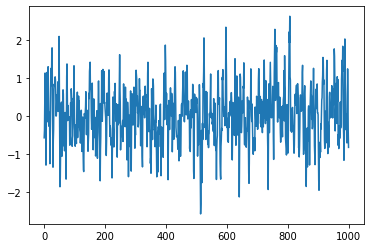

In [2]:
data = []

with open("MAdata.txt", "r") as f:
    for line in f:
        data.append(float(line))
        
data = np.array(data)
plt.plot(data)

### Two step regression: step 1

In [3]:
def dividing_data_into_subseries_II(data, k=2):
    X = []
    Y = []
    for i in range(len(data)-k):
        tmp = []
        for j in range(k):
            tmp.append(data[j+i])
        X.append(tmp)
        Y.append(data[k+i] )
    
    return np.array(X), np.array(Y)

In [4]:
X,Y = dividing_data_into_subseries_II(data, k=5) 

reg = LinearRegression(fit_intercept = True).fit(X, Y)
prediction = reg.predict(X)

print("fitted coefficients  beta_(t-4)...beta_(t-1): {:}".format(reg.coef_) )

eps = Y - reg.predict(X)
eps = eps/eps.std()

print("\nmean= {:2f}\t std = {:2f}".format( eps.mean(), eps.std()))

fitted coefficients  beta_(t-4)...beta_(t-1): [-0.12012871  0.36018872 -0.37838572 -0.08674498  0.80444727]

mean= -0.000000	 std = 1.000000


In [5]:
YY = np.vstack((Y,eps)).transpose()
np.hstack((YY, X))

df = pd.DataFrame(np.hstack((X,YY)), columns = ['y(t5)', 'y(t4)', 'y(t3)', 'y(t2)', 'y(t1)', 'y(t)', 'eps'])

df['eps-1'] = df['eps'].shift(-1)
df['eps-2'] = df['eps'].shift(-2)
df['eps-3'] = df['eps'].shift(-3)
df['eps-4'] = df['eps'].shift(-4)
df['eps-5'] = df['eps'].shift(-5)

df['eps+1'] = df['eps'].shift(1)
df['eps+2'] = df['eps'].shift(2)
df['eps+3'] = df['eps'].shift(3)
df['eps+4'] = df['eps'].shift(4)
df['eps+5'] = df['eps'].shift(5)

df.dropna(inplace = True)
df

,y(t5),y(t4),y(t3),y(t2),y(t1),y(t),eps,eps-1,eps-2,eps-3,eps-4,eps-5,eps+1,eps+2,eps+3,eps+4,eps+5
5,-0.192600,-1.299081,-0.226935,0.065571,1.144725,0.265750,-0.576152,-0.627442,1.561935,1.439632,-0.553278,-0.254515,1.340070,0.090356,1.110229,-1.616030,-0.488669
6,-1.299081,-0.226935,0.065571,1.144725,0.265750,-0.153007,-0.627442,1.561935,1.439632,-0.553278,-0.254515,0.024647,-0.576152,1.340070,0.090356,1.110229,-1.616030
7,-0.226935,0.065571,1.144725,0.265750,-0.153007,0.284510,1.561935,1.439632,-0.553278,-0.254515,0.024647,0.333815,-0.627442,-0.576152,1.340070,0.090356,1.110229
8,0.065571,1.144725,0.265750,-0.153007,0.284510,1.295828,1.439632,-0.553278,-0.254515,0.024647,0.333815,-0.782455,1.561935,-0.627442,-0.576152,1.340070,0.090356
9,1.144725,0.265750,-0.153007,0.284510,1.295828,0.755126,-0.553278,-0.254515,0.024647,0.333815,-0.782455,-2.199992,1.439632,1.561935,-0.627442,-0.576152,1.340070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,-0.101703,0.536068,2.027797,0.977956,0.555992,-0.363077,-0.330069,0.143503,0.160003,-1.860632,0.109108,1.218314,0.071871,-0.564649,2.514021,0.890813,1.395357
987,0.536068,2.027797,0.977956,0.555992,-0.363077,0.036522,0.143503,0.160003,-1.860632,0.109108,1.218314,1.480871,-0.330069,0.071871,-0.564649,2.514021,0.890813
988,2.027797,0.977956,0.555992,-0.363077,0.036522,0.048544,0.160003,-1.860632,0.109108,1.218314,1.480871,-0.743832,0.143503,-0.330069,0.071871,-0.564649,2.514021
989,0.977956,0.555992,-0.363077,0.036522,0.048544,-0.697383,-1.860632,0.109108,1.218314,1.480871,-0.743832,-1.093246,0.160003,0.143503,-0.330069,0.071871,-0.564649


### Two step regression: step 2

In [6]:
def get_AIC_BIC(df, x_cols):
    
    k=len(x_cols)
    Y = np.array(df['y(t)'])
    X = np.array(df[x_cols])
    
    reg = LinearRegression(fit_intercept = False).fit(X, Y)
    prediction = reg.predict(X)
    N = len(X)
    
    alpha = np.sqrt(((Y-prediction)**2).mean())   
    AIC = N*np.log(((Y-prediction)**2).mean()) + 2*k   
    BIC = N*np.log(((Y-prediction)**2).mean()) + np.log(N)*k    
    
    print("\n\nk = {:}, alpha = {:}\t AIC = {:}\t BIC = {:}\n".format(k,alpha, AIC, BIC))
    print("reg.coef_ = {:}\tintercept = {:}".format(reg.coef_, reg.intercept_) )
    
    return [k, alpha, AIC, BIC]

In [7]:
tab = []

tab.append(get_AIC_BIC(df, ['eps+1'] ))
tab.append(get_AIC_BIC(df, ['eps+1', 'eps+2'] ))
tab.append(get_AIC_BIC(df, ['eps+1', 'eps+2', 'eps+3'] ))
tab.append(get_AIC_BIC(df, ['eps+1', 'eps+2', 'eps+3', 'eps+4'] ))
tab.append(get_AIC_BIC(df, ['eps+1', 'eps+2', 'eps+3', 'eps+4', 'eps+5'] ))



k = 1, alpha = 0.599340117386145	 AIC = -1007.5181377682172	 BIC = -1002.6244814136146

reg.coef_ = [0.406073]	intercept = 0.0


k = 2, alpha = 0.5113506601881491	 AIC = -1318.6198097053011	 BIC = -1308.8324969960959

reg.coef_ = [0.41126442 0.31314482]	intercept = 0.0


k = 3, alpha = 0.5110212923940226	 AIC = -1317.8904105093382	 BIC = -1303.2094414455303

reg.coef_ = [ 0.41214415  0.31286094 -0.0183911 ]	intercept = 0.0


k = 4, alpha = 0.5110147486407275	 AIC = -1315.9156626158785	 BIC = -1296.341037197468

reg.coef_ = [ 0.412248    0.31273797 -0.01835132  0.00259062]	intercept = 0.0


k = 5, alpha = 0.5100592842410672	 AIC = -1317.6062399597208	 BIC = -1293.1379581867077

reg.coef_ = [ 0.41243666  0.31402256 -0.01982767  0.00304693  0.03128732]	intercept = 0.0


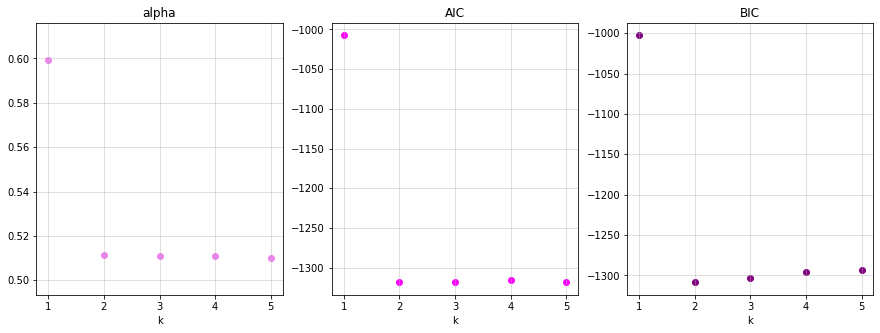

In [8]:
k_tab, alpha_tab, AIC_tab, BIC_tab = np.array(tab).transpose()

fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (15,5))

for ax in axs:
    ax.set_xlabel('k')
    ax.grid(True, alpha = 0.5)
    
axs[0].set_title('alpha')
axs[1].set_title('AIC')
axs[2].set_title('BIC')
    
axs[0].scatter(k_tab, alpha_tab, color = 'violet')
axs[1].scatter(k_tab, AIC_tab, color = 'fuchsia')
axs[2].scatter(k_tab, BIC_tab, color = 'purple')

It seems like q=2 is the order of MA(q) process

* $\beta_1 = 0.41126442$ (coefficient at eps+1)
* $\beta_2 = 0.31314482$ (coefficient at eps+2)
* $intercept = 0.0$

In [9]:
q=2 
Y = np.array(df['y(t)'])
X = np.array(df[['eps+1','eps+2']])
    
reg = LinearRegression(fit_intercept = False).fit(X, Y)
prediction = reg.predict(X)
N = len(Y)

alpha_0 = np.sqrt(((Y-prediction )**2).mean())
AIC = N*np.log(((Y-prediction)**2).mean() )+ 2*q   
BIC = N*np.log(((Y-prediction)**2).mean()) + np.log(N)*q    
   
print("\n\nq = {:}, alpha = {:}\t AIC = {:}\t BIC = {:}\n".format(q,alpha_0, AIC, BIC))
print("reg.coef_ = {:}\tintercept = {:}".format(reg.coef_, reg.intercept_) )
    



q = 2, alpha = 0.5113506601881491	 AIC = -1318.6198097053011	 BIC = -1308.8324969960959

reg.coef_ = [0.41126442 0.31314482]	intercept = 0.0


# b) 
Compute  the  sample autocorrelation function (SACF, $\rho(t)$ and the sample partial autocorrelation function (SPACF,$\phi(t)$) and plot them for $t= 1,...10$. Based on the plot of SPACF check the orderp (on the plot include Gaussian N(0,(T−t)−1) bands for $95\%$ confidence level to check when SPACF becomes statistically zero).

In [10]:
def dividing_data_into_subseries(data, k=2, k_max=11):
    data_k = []
    for i in range(len(data)-k_max):
        tmp = [ ]
        for j in range(k):
            tmp.append(data[j+i])
        tmp.append(data[k+i])
        data_k.append(tmp)
    return np.array(data_k).T

In [11]:
def get_autocorrelation_coeff(data, delta):
    
    data_k = dividing_data_into_subseries(data, k=delta)  
    denominator = (data**2).mean()
    nominator = (data_k[0]*data_k[-1]).mean()
    
    return nominator/denominator
    

In [12]:
def get_autocorrelation(p,data):
    
    autocorrelation_tab = []

    for delta in range(1,p+1):
        autocorrelation = get_autocorrelation_coeff(data, delta)
        autocorrelation_tab.append(autocorrelation)
    
    return autocorrelation_tab

### sample autocorrelation function (SACF)

Δt = 1	 ρ(Δt)=0.639600
Δt = 2	 ρ(Δt)=0.294154
Δt = 3	 ρ(Δt)=-0.003510
Δt = 4	 ρ(Δt)=0.014596
Δt = 5	 ρ(Δt)=0.010283
Δt = 6	 ρ(Δt)=-0.027150
Δt = 7	 ρ(Δt)=-0.075388
Δt = 8	 ρ(Δt)=-0.090840
Δt = 9	 ρ(Δt)=-0.086528
Δt = 10	 ρ(Δt)=-0.062394


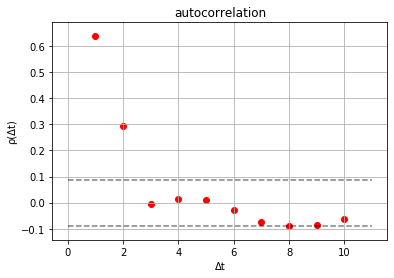

In [13]:
p=10
p_tab = list(range(1,p+1))
autocorrelation_tab = get_autocorrelation(p,data)

for delta_t, corr in zip(p_tab, autocorrelation_tab):
    print(u'\u0394t = {:}\t \u03C1(\u0394t)={:2f}'.format(delta_t,corr ))

N = 490
confidence_level = 1.96/np.sqrt(N)


plt.title('autocorrelation')
plt.scatter(p_tab, autocorrelation_tab, color ='red')  
plt.ylabel(u'\u03C1(\u0394t)')
plt.xlabel(u'\u0394t')
plt.grid()

plt.hlines(y = confidence_level, xmin=0, xmax = p+1, linestyles='dashed', color = 'black', alpha = 0.5)
plt.hlines(y = -confidence_level, xmin=0, xmax = p+1, linestyles='dashed', color = 'black', alpha = 0.5)


###  Partial autocorrelation function (PACF)

In [14]:
def get_partial_autocorrelation(p, data):
    
    autocorrelation_tab = get_autocorrelation(p,data)
    
    M = np.identity(p)*0.5
    for i in range(p):
        for j in range(i+1, p):
            M[i][j] = autocorrelation_tab[j-i-1]
    
    A = np.matrix(M.T + M)
    A_inv = np.linalg.inv(A) 
    
    psi_vec = np.array(np.dot(A_inv,autocorrelation_tab))[0]
    
    return psi_vec[-1]

Δt = 1	 Φ(Δt)=0.639600
Δt = 2	 Φ(Δt)=-0.194504
Δt = 3	 Φ(Δt)=-0.182638
Δt = 4	 Φ(Δt)=0.273179
Δt = 5	 Φ(Δt)=-0.125215
Δt = 6	 Φ(Δt)=-0.128887
Δt = 7	 Φ(Δt)=0.086820
Δt = 8	 Φ(Δt)=-0.060005
Δt = 9	 Φ(Δt)=-0.071853
Δt = 10	 Φ(Δt)=0.060464


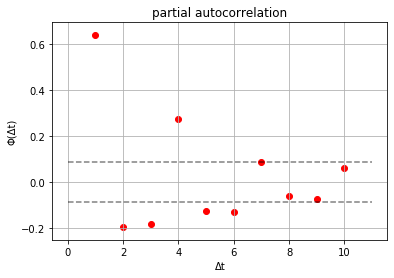

In [19]:
p=10
p_tab = list(range(1,p+1))
partial_corr_tab_tab = []

for k in range(1,p+1):
    partial_corr_tab_tab.append(get_partial_autocorrelation(k,data))


for delta_t, p_corr in zip(p_tab, partial_corr_tab_tab):
    print(u'\u0394t = {:}\t \u03A6(\u0394t)={:2f}'.format(delta_t, p_corr ))

    
plt.title('partial autocorrelation')
plt.scatter(p_tab, partial_corr_tab_tab, color ='red')  
plt.ylabel(u'\u03A6(\u0394t)')
plt.xlabel(u'\u0394t')
plt.grid()
plt.hlines(y = confidence_level, xmin=0, xmax = p+1, linestyles='dashed', color = 'black', alpha = 0.5)
plt.hlines(y = -confidence_level, xmin=0, xmax = p+1, linestyles='dashed', color = 'black', alpha = 0.5)

Based on the above two plots we see that autocorrelation drops abruptly to 0 (with confidence level $95\%$) after $q=2$. So the order of MA(q) process is 2.

# c

###  Autocorrelation matrix  and  Yule Walker Equations

For the order $p$ established in (b) fit the parameters: $\beta_i (i=1,...,p)$ and $\alpha_0$ using the Yule-Walkermethod (in the matrix form).

In [16]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
def dividing_data_into_subseries(data, k=2):
    data_k = []
    for i in range(len(data)-k):
        tmp = [ ]
        for j in range(k):
            tmp.append(data[j+i])
        tmp.append(data[k+i])
        data_k.append(tmp)  
    return np.array(data_k).T

In [ ]:
data_1 = dividing_data_into_subseries(data, k=1)  #q=1
data_2 = dividing_data_into_subseries(data, k=2)  #q=2
data_3 = dividing_data_into_subseries(data, k=3)  #q=3
data_4 = dividing_data_into_subseries(data, k=4)  #q=4
data_5 = dividing_data_into_subseries(data, k=5)  #q=5


We are looking for the autocorrelation function $ACF \equiv \rho\Delta t$

$$ <y_ty_{\Delta t}> = <y_t^2>\rho_{\Delta t}$$

$$ y_t = \sum_{i=0}^g\alpha_i\eta_{t-i}$$

$$ y_{t-\Delta t} = \sum_{i=0}^g\alpha_j\eta_{t-\Delta t -j}$$
$$ <y_ty_{t-\Delta t}> =  \sum_{i=0}^g\sum_{j=0}^g<\eta_{t-i}\eta_{t-\Delta t -h}> = \sum_{i=\Delta t}^g \alpha_i \alpha_{i-\Delta t} $$

In [ ]:
cov0 = (data**2).mean()
cov1 = (data_1[0]*data_1[-1]).mean()
cov2 = (data_2[0]*data_2[-1]).mean()
cov3 = (data_3[0]*data_3[-1]).mean()
cov4 = (data_4[0]*data_4[-1]).mean()
cov5 = (data_5[0]*data_5[-1]).mean()

print("cov0 = {:2f}\t cov1 = {:2f}\t cov2 = {:2f} \
        \tcov3 = {:2f} \tcov4 = {:2f}\ncov5 = {:2f}".format(cov0, cov1,cov2,cov3,cov4,cov5))

### Yule Walker Equations:


* MA(1):
$$ <y_ty_t>=\alpha_0^2+\alpha_1^2 $$
$$ <y_ty_{t-1}>=\alpha_0\cdot\alpha_1 $$

* MA(2):
$$ <y_ty_t>=\alpha_0^2+\alpha_1^2 +\alpha_2^2 $$
$$ <y_ty_{t-1}>=\alpha_0\alpha_1 +\alpha_1\alpha_2 $$
$$ <y_ty_{t-2}>=\alpha_0\alpha_2 $$

* MA(3):
$$ <y_ty_t>=\alpha_0^2+\alpha_1^2 +\alpha_2^2 +\alpha_3^2$$
$$ <y_ty_{t-1}>=\alpha_0\alpha_1 +\alpha_1\alpha_2+\alpha_2\alpha_3$$
$$ <y_ty_{t-2}>=\alpha_0\alpha_2 +\alpha_1\alpha_3 $$
$$ <y_ty_{t-3}>=\alpha_0\alpha_3 $$

* MA(4):
$$ <y_ty_t>=\alpha_0^2+\alpha_1^2 +\alpha_2^2 +\alpha_3^2+\alpha_4^2$$
$$ <y_ty_{t-1}>=\alpha_0\alpha_1 +\alpha_1\alpha_2+\alpha_2\alpha_3+\alpha_3\alpha_4$$
$$ <y_ty_{t-2}>=\alpha_0\alpha_2 +\alpha_1\alpha_3 +\alpha_2\alpha_4 $$
$$ <y_ty_{t-3}>=\alpha_0\alpha_3+\alpha_1\alpha_4 $$
$$ <y_ty_{t-4}>=\alpha_0\alpha_4$$

In [ ]:
from sympy.solvers.solveset import nonlinsolve

alpha0, alpha1, alpha2, alpha3, alpha4, alpha5 = symbols('alpha0 alpha1 alpha2 alpha3 alpha4 alpha5', real=True)
x = symbols('x')

In [ ]:
## q=1

f1 = cov0-alpha0**2-alpha1**2
f2 = cov1-alpha0*alpha1

sol_q1 = solve( [f1,f2], set = True)
sol_q1 = sol_q1[1]
sol_q1

In [ ]:
## q=2

f1=cov0-alpha0**2-alpha1**2-alpha2**2
f2=cov1-alpha0*alpha1-alpha1*alpha2
f3=cov2-alpha0*alpha2

sol_q2 = solve( [f1,f2,f3], set = True)
sol_q2 = sol_q2[1]
sol_q2

#####  q=3

f1=cov0-alpha0**2-alpha1**2-alpha2**2-alpha3**2
f2=cov1-alpha0*alpha1-alpha1*alpha2-alpha2*alpha3
f3=cov2-alpha0*alpha2-alpha1*alpha3
f4=cov3-alpha0*alpha3

sol_q3 = solve( [f2,f3,f4], [alpha0, alpha1,alpha2,alpha3], rational=False)
sol_q3

##### q=4

f1=cov0-alpha0**2-alpha1**2-alpha2**2-alpha3**2-alpha4**2
f2=cov1-alpha0*alpha1-alpha1*alpha2-alpha2*alpha3-alpha3*alpha4
f3=cov2-alpha0*alpha2-alpha1*alpha3-alpha2*alpha4
f4=cov3-alpha0*alpha3-alpha1*alpha4
f5= cov4-alpha0*alpha4

sol_q4 = solve( [f1,f2,f3,f4,f5], set = True)
sol_q4

In [ ]:
sol_q3 = {(-0.514414, -0.412154,-0.2994, 0.00771364),
          (0.514414, 0.412154, 0.2994, -0.00771364),
          (0.0128011, -0.503839, -0.417242,-0.309974),
          (-0.0128011, 0.503839,0.417242,0.309974),
          (0.00771364,-0.2994, -0.412154, -0.514414),
          (-0.00771364, 0.2994, 0.412154, 0.514414),
          (-0.309974, -0.417242,-0.503839, 0.0128011),
          (0.309974, 0.417242, 0.503839, -0.0128011)
}

In [ ]:
sol_q4 =  {(0.504261, 0.418544, 0.306812,  -0.0198107, 0.0143874),
           (-0.504261,-0.418544,-0.306812,   0.0198107, -0.0143874),
           (-0.0212497,0.0388579,-0.462795,  -0.437592, -0.341416),
           (0.0212497,-0.0388579,0.462795,   0.437592,  0.341416),
           (0.0143874, -0.0198107,0.306812,  0.418544,  0.504261),
           (-0.0143874, 0.0198107,-0.306812, -0.418544, -0.504261), 
           (0.341416,  0.437592, 0.462795,  -0.0388579, 0.0212497)}



In [ ]:
sol_q5 = {(-0.0356633, 0.0829034, -0.200271, -0.326877, -0.584941, -0.164118),  
          (0.0356633, -0.0829034, 0.200271, 0.326877, 0.584941, 0.164118),
          (-0.164118, -0.584941, -0.326877, -0.200271, 0.0829034, -0.0356633),
          (0.164118,   0.584941,  0.326877,  0.200271, -0.0829034,  0.0356633),
          (-0.502879, -0.415566, -0.313187, 0.019113, -0.00480879, -0.011639), 
          (0.502879,   0.415566,  0.313187, -0.019113, 0.00480879, 0.011639),
          (0.011639,   0.00480879,-0.019113, 0.313187, 0.415566, 0.502879),
          (-0.011639, -0.00480879,0.019113, -0.313187, -0.415566, -0.502879),
          (0.0503457, -0.13551,   0.313511, 0.427345, 0.457018, 0.116256),
          (-0.0503457, 0.13551,  -0.313511, -0.427345,-0.457018, -0.116256),
          (0.116256,   0.457018,  0.427345,  0.313511, -0.13551, 0.0503457),
          (-0.116256, -0.457018, -0.427345,  -0.313511, 0.13551, -0.0503457),
          (0.0164307,  0.000758754, -0.0334413, 0.463892, 0.425102, 0.356224),
          (-0.0164307,-0.000758754, 0.0334413, -0.463892, -0.425102, -0.356224),
          (0.356224,   0.425102,  0.463892,   -0.0334413,  0.000758754, 0.0164307),
          (-0.356224, -0.425102, -0.463892,   0.0334413,  -0.000758754, -0.0164307) }



In [ ]:
def get_roots(X,ceoffs):
    return solve(sum(list(map(lambda x,y: x*y, X,coeffs))))

In [ ]:
X = [1,x,x**2]

for coeffs in list(sol_q2):
    print("\ncoeffs:\t", coeffs)
    print("roots:\t",get_roots(X, coeffs))
    
    get_roots(X, coeffs)
    

In [ ]:
X = [1,x,x**2,x**3]

for coeffs in list(sol_q3):
    print("\ncoeffs:\t", coeffs)
    print("roots:\t",get_roots(X, coeffs))
    
    get_roots(X, coeffs)

In [ ]:
X = [1,x,x**2,x**3, x**4]

for coeffs in list(sol_q4):
    print("\ncoeffs:\t", coeffs)
    print("roots:\t",get_roots(X, coeffs))
    
    get_roots(X, coeffs)

In [ ]:
X = [1,x,x**2,x**3,x**4,x**5]

for coeffs in list(sol_q5):
    print("\ncoeffs:\t", coeffs)
    print("roots:\t",get_roots(X, coeffs))
    
    get_roots(X, coeffs)

$$\sum a_iz^i = 0$$
If we take only $a_i$'s such that the roots $|z|>0$, we are left with:

* q=1 - no solutions
* q=2 - coeffs:	 (0.289485433038988, 0.410972423453576, 0.521048424658716)
        coeffs:	 (-0.289485433038988, -0.410972423453576, -0.521048424658716)

* q=3 - coeffs:	 (0.00771364, -0.2994, -0.412154, -0.514414)
        coeffs:	 (-0.00771364, 0.2994, 0.412154, 0.514414)
